In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import numpy as np 
import pandas as pd 

#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [37]:
#models and evaluation

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from nltk.classify.scikitlearn import SklearnClassifier # notice its from ntlk not sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# Evaluation packages
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [4]:
filename1="newsCorpora.csv"
filename2="2pageSessions.csv"

In [5]:
df=pd.read_csv(filename1,sep='\t', header=None)
df.head()

,0,1,2,3,4,5,6,7
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [6]:
header_list = ["id", "title", "url","publisher","category","story","hostname","timestamp"]
df=pd.read_csv(filename1,sep='\t', names=header_list)
df.shape

(422419, 8)

In [7]:
df.head(2)

,id,title,url,publisher,category,story,hostname,timestamp
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207


In [8]:
df.category.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: category, dtype: int64

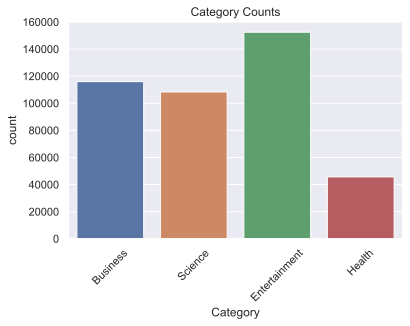

In [9]:
cat_map = {
    'b': 'Business',
    't': 'Science',
    'e': 'Entertainment',
    'm': 'Health'
}
ax = sns.countplot(df['category'])
ax.set_title("Category Counts")
ax.set_xlabel("Category")
# Manipulate the labels to make them more readable
ax.set_xticklabels([cat_map[x.get_text()] for x in ax.get_xticklabels()], rotation=45)
plt.show()


In [10]:
from collections import Counter

# Byte magic to style print output. 
#Reference https://stackoverflow.com/questions/62131164/how-to-return-bold-characters-in-python-terminal
def emphasize(s):
    """Bold the string to help get the print reader's attention.
    
    Parameters
    ----------
    s : str
        String to be decorated with bold.
    
    Returns
    -------
    str
        The string in bold.
    """
    green= '\033[92m'
    stop = '\x1b[0m'
    return green + str(s) + stop

nunique = df['publisher'].nunique()
print("There are {} different publishers. Below some of the most common:".format(emphasize(nunique)))
for key, value in Counter(df['publisher']).most_common(5):
    print("   {} posted {} articles".format(emphasize(key), emphasize(value)))

There are 10985 different publishers. Below some of the most common:
   Reuters posted 3902 articles
   Huffington Post posted 2455 articles
   Businessweek posted 2395 articles
   Contactmusic.com posted 2334 articles
   Daily Mail posted 2254 articles


In [11]:
df_page=pd.read_csv(filename2,sep='\t', header=None)
df_page.head()

,0,1,2,3
0,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,techcrunch.com,b,http://techcrunch.com/ http://techcrunch.com/2...
1,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,techcrunch.com,b,http://techcrunch.com/ecommerce/ http://techcr...
2,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,www.bnn.ca,b,http://www.bnn.ca/News/2014/ http://www.bnn.ca...
3,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,www.bnn.ca,b,http://www.bnn.ca/news http://www.bnn.ca/News/...
4,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,www.bnn.ca,b,http://www.bnn.ca/News/News-Listing.aspx?Secto...


In [12]:
header_list2 = ["story","hostname","category","url"]
df_page=pd.read_csv(filename2,sep='\t', names=header_list2)
df_page.head(2)

,story,hostname,category,url
0,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,techcrunch.com,b,http://techcrunch.com/ http://techcrunch.com/2...
1,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,techcrunch.com,b,http://techcrunch.com/ecommerce/ http://techcr...


In [13]:
df_page.shape

(15516, 4)

In [14]:
df_page.url[0]

'http://techcrunch.com/ http://techcrunch.com/2014/03/10/ebay-asks-shareholders-to-vote-against-paypal-split-while-icahn-claims-ceo-incompetence-cost-4b/ '

In [15]:
df_page.category.value_counts()

e    9425
b    6091
Name: category, dtype: int64

### Work with timestamp

In [19]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.head(2)

,id,title,url,publisher,category,story,hostname,timestamp
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,2014-03-10 16:52:50.698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,2014-03-10 16:52:51.207


In [20]:
def start_end(dates):
    return "{}/{}/{}".format(dates.day, dates.month, dates.year)

In [21]:
start= df['timestamp'].min()
end=df['timestamp'].max() 

In [22]:
print("Our dataset timeline starts at {} and ends at {}".format(start_end(start), start_end(end)))

Our dataset timeline starts at 10/3/2014 and ends at 28/8/2014


In [23]:
df['year'] = df['timestamp'].apply(lambda date: date.year)
df['months'] = df['timestamp'].apply(lambda date: date.month)
df['day'] = df['timestamp'].apply(lambda date: date.day)

In [24]:
df.head(2)

,id,title,url,publisher,category,story,hostname,timestamp,year,months,day
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,2014-03-10 16:52:50.698,2014,3,10
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,2014-03-10 16:52:51.207,2014,3,10


In [25]:
df.months.nunique()

6

In [26]:
df.months.unique()

array([3, 4, 5, 6, 7, 8], dtype=int64)

In [27]:
df.day.nunique()

31

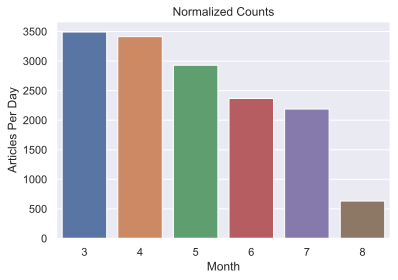

In [28]:
month_days = {
    3: 21, 
    4: 30,
    5: 31,
    6: 30,
    7: 31,
    8: 27
}
articles_per_day = {}
for month in month_days:
    n_articles = len(df[df['months'] == month])
    articles_per_day[month] = n_articles / month_days[month]

ax = sns.barplot(x=list(articles_per_day.keys()), y=list(articles_per_day.values()))
ax.set_title("Normalized Counts")
ax.set_xlabel("Month")
ax.set_ylabel("Articles Per Day")
plt.show()

There are very few news in August month though we have got data for 28 days

### merge with story, or url or hostname

In [29]:
df.isnull().sum()

id           0
title        0
url          0
publisher    2
category     0
story        0
hostname     0
timestamp    0
year         0
months       0
day          0
dtype: int64

In [30]:
df_page.isnull().sum()

story       0
hostname    0
category    0
url         0
dtype: int64

# Model Sample

In [34]:
df.head(2)

,id,title,url,publisher,category,story,hostname,timestamp,year,months,day,cat_num
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,2014-03-10 16:52:50.698,2014,3,10,1
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,2014-03-10 16:52:51.207,2014,3,10,1


In [31]:
df.category.unique()

array(['b', 't', 'e', 'm'], dtype=object)

In [32]:
df['cat_num']= df['category'].map({'b':1, 't': 2 ,'e':3, 'm':4})

In [33]:
df.cat_num.value_counts()

3    152469
1    115967
2    108344
4     45639
Name: cat_num, dtype: int64

### split X and y

In [35]:
X = df['title']
y = df['cat_num']

### Countvec and Model

In [38]:
# Extract Feature With CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(X) # Fit the Data

In [39]:
X.shape

(422419, 54637)

In [40]:
clf = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
clf.fit(X,y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Out of sample data

https://github.com/HassanSherwani/Model_Deployment/tree/master/Sentiment_Analysis(json)

In [41]:
message=["US jobs growth last month hit by weather:Fed President Charles Plosser"]
vect = pd.DataFrame(cv.transform(message).toarray())
my_prediction = clf.predict(vect)
my_prediction

array([1], dtype=int64)

In [42]:
score=clf.predict_proba(vect)
score

array([[0.98251183, 0.01369128, 0.00205359, 0.0017433 ]])

In [44]:
prob=score.max(axis=1)
prob

array([0.98251183])

In [45]:
result=message
result=pd.DataFrame(result,columns=["text"])
result["news-type"]=my_prediction
result["news-type"]=result['news-type'].map({1 : "b", 2 : "t", 3 :"e", 4:"m"})
result["probability"]=prob

In [46]:
result

,text,news-type,probability
0,US jobs growth last month hit by weather:Fed P...,b,0.982512


In [47]:
json_table = result.to_json(orient='records')  
json_table

'[{"text":"US jobs growth last month hit by weather:Fed President Charles Plosser","news-type":"b","probability":0.9825118325}]'

### 2nd example

In [48]:
message=["YouTube updates to include crowd-funding options"]
vect = pd.DataFrame(cv.transform(message).toarray())
my_prediction = clf.predict(vect)
score=clf.predict_proba(vect)
prob=score.max(axis=1)

In [49]:
result=message
result=pd.DataFrame(result,columns=["text"])
result["news-type"]=my_prediction
result["news-type"]=result['news-type'].map({1 : "b", 2 : "t", 3 :"e", 4:"m"})
result["probability"]=prob

In [50]:
json_table = result.to_json(orient='records')  
json_table

'[{"text":"YouTube updates to include crowd-funding options","news-type":"t","probability":0.6283026096}]'